<span style="color: red; font-size: 32px;">Finetuning Project</span>


## In this notebook I have used MobileNet as my pre-trained model and worked on that!!

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/galaxy-zoo-the-galaxy-challenge/all_ones_benchmark.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/images_test_rev1.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/central_pixel_benchmark.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/all_zeros_benchmark.zip
/kaggle/input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip


## Importing required Libraries

In [ ]:
# Standard libraries
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K


## Loading the data 

In [3]:
data = pd.read_csv("../input/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.zip",
                   compression="zip")

#data = pd.read_csv('training_solutions_rev1.csv')
data.head(5)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [4]:
data.shape

(61578, 38)

In [5]:
def append_ext(filename):
    """ Appends `.jpg` file extension to a filename """
    return f"{filename}.jpg"
    #return filename + '.jpg'

#applying the function to the GalaxyID colunm
data["GalaxyID"] = data["GalaxyID"].apply(append_ext)

#printing the first five row of the dataframe to view the changes
data.head(5)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008.jpg,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023.jpg,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053.jpg,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078.jpg,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090.jpg,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Preparing the dataset

In [ ]:
new_data = data[
    (data["Class1.1"] >= 0.7) |  # Elliptical
    (data["Class1.2"] >= 0.7) |  # Spiral
    (data["Class2.1"] >= 0.7) |  # Barred Spiral
    (data["Class2.2"] >= 0.7) |  # Irregular
    (data["Class3.1"] >= 0.7)    # Lenticular
].reset_index(drop=True)

# # Apply the resolve_classes function to assign one or multiple classes to each row
# Define the resolve_classes function for all 5 classes
def resolve_classes(row):
    classes = []
    if row["Class1.1"] >= 0.8:
        classes.append("Elliptical")
    if row["Class1.2"] >= 0.8:
        classes.append("Spiral")
    if row["Class2.1"] >= 0.7:
        classes.append("Merger")
    if row["Class3.1"] >= 0.5:
        classes.append("Lenticular")
    return ", ".join(classes)

# Apply the resolve_classes function to assign classes to each row in new_data
new_data["class"] = new_data.apply(resolve_classes, axis=1)




In [7]:
new_data["class"].value_counts()

class
                      11693
Spiral                11030
Elliptical             8132
Spiral, Lenticular     2819
Spiral, Merger         2292
Merger                  543
Lenticular              303
Name: count, dtype: int64

In [8]:
# Check if there are any rows with "Tie" in the "class" column before sampling
if "Tie" in new_data["class"].values:
    # Undersample or oversample each class to balance the dataset
    df_tie = new_data[new_data["class"] == "Tie"].sample(n=8000, random_state=42, replace=False)
    print("This is a sample of Tie galaxies")
    print(df_tie.head(5))
else:
    print("No Tie galaxies found in the dataset.")


No Tie galaxies found in the dataset.


## Balancing the dataset

In [9]:
# #Undersample or oversample each class to balance the dataset

df_spiral_irregular = new_data[new_data["class"] == "Spiral"].sample(n=5000, random_state=42, replace=False)
print("This is a sample of spiral/irregular galaxies")
print(df_spiral_irregular.head(5))
print(df_spiral_irregular.shape)

df_elliptical = new_data[new_data["class"] == "Elliptical"].sample(n=5000, random_state=42, replace=True)
print("This is a sample of elliptical galaxies")
print(df_elliptical.head(5))
print(df_elliptical.shape)

df_spiral = new_data[new_data["class"] == "Lenticular"].sample(n=5000, random_state=42, replace=True)
print("This is a sample of spiral galaxies")
print(df_spiral.head(5))
print(df_spiral.shape)

df_spiral_barred = new_data[new_data["class"] == "Spiral, Lenticular"].sample(n=2500, random_state=42, replace=True)
print("This is a sample of spiral/barred spiral galaxies")
print(df_spiral_barred.head(5))
print(df_spiral_barred.shape)

df_spiral_irregular_lenticular = new_data[new_data["class"] == "Spiral, Merger"].sample(n=2500, random_state=42, replace=True)
print("This is a sample of spiral/irregular/lenticular galaxies")
print(df_spiral_irregular_lenticular.head(5))
print(df_spiral_irregular_lenticular.shape)

# Combine all balanced samples into one DataFrame
balanced_data = pd.concat([df_spiral_irregular, df_elliptical, df_spiral, df_spiral_barred, df_spiral_irregular_lenticular])

# Check the distribution to confirm balance
print("Balanced data class distribution:")
print(balanced_data["class"].value_counts())


This is a sample of spiral/irregular galaxies
         GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
26831  755358.jpg  0.050193  0.946650  0.003156  0.078857  0.867793  0.377288   
5379   233208.jpg  0.036000  0.964000  0.000000  0.000000  0.964000  0.071336   
26765  753911.jpg  0.022000  0.978000  0.000000  0.021516  0.956484  0.217122   
16318  501405.jpg  0.037300  0.951107  0.011593  0.107942  0.843165  0.299054   
24013  686013.jpg  0.067239  0.932462  0.000300  0.043401  0.889061  0.019947   

       Class3.2  Class4.1  Class4.2  ...  Class10.1  Class10.2  Class10.3  \
26831  0.490505  0.737475  0.130318  ...   0.162543   0.000000   0.574932   
5379   0.892664  0.964000  0.000000  ...   0.892664   0.071336   0.000000   
26765  0.739362  0.956484  0.000000  ...   0.217122   0.630323   0.109039   
16318  0.544111  0.779406  0.063758  ...   0.094088   0.156362   0.528956   
24013  0.869115  0.715582  0.173479  ...   0.338947   0.223939   0.152696   

    

In [10]:
frames = [df_spiral, df_elliptical,df_spiral_irregular,df_spiral_barred,df_spiral_irregular_lenticular]
df_galaxies = pd.concat(frames)
df_galaxies = df_galaxies[["GalaxyID", "class"]]
df_galaxies.head()


,GalaxyID,class
11163,374660.jpg,Lenticular
33110,909665.jpg,Lenticular
12517,406249.jpg,Lenticular
7521,286727.jpg,Lenticular
22289,646198.jpg,Lenticular


## Unzipping 

In [11]:
import zipfile
with zipfile.ZipFile("../input/galaxy-zoo-the-galaxy-challenge/images_training_rev1.zip", 'r') as zip_ref:
    zip_ref.extractall()

Text(0.5, 1.02, 'Elliptical Galaxy')

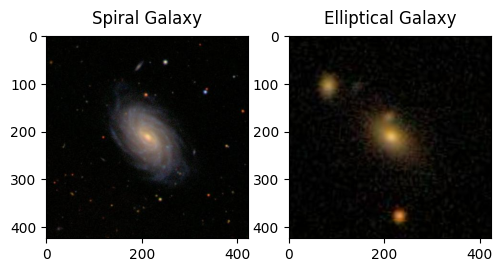

In [12]:
# Printing two random images
#images
img= image.load_img("./images_training_rev1/104934.jpg")
img2 = image.load_img("./images_training_rev1/582003.jpg")

#Subplots
plt.figure(figsize=(12,4.5))
plt.subplot(141)
plt.imshow(img)
plt.title("Spiral Galaxy", y=1.02, fontsize=12)

plt.subplot(142)
plt.imshow(img2)
plt.title("Elliptical Galaxy", y=1.02, fontsize=12)

In [13]:
import cv2

print("The images are of size: ")
cv2.imread("./images_training_rev1/104934.jpg").shape

The images are of size: 


(424, 424, 3)

## Pre-Processing the dataset

In [15]:


# Split your dataframe into train+valid and test
train_valid_df, test_df = train_test_split(df_galaxies, test_size=0.2, random_state=42, stratify=df_galaxies['class'])

# Further split train_valid_df into train and validation
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42, stratify=train_valid_df['class'])  # 0.25 x 0.8 = 0.2

# Create the data generator for training and validation with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=(224, 224),
    directory="./images_training_rev1",
    batch_size=32,
    x_col="GalaxyID",
    y_col="class",
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    target_size=(224, 224),
    directory="./images_training_rev1",
    batch_size=32,
    x_col="GalaxyID",
    y_col="class",
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=42
)

# Create a test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for the test set

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=(224, 224),
    directory="./images_training_rev1",
    batch_size=32,
    x_col="GalaxyID",
    y_col="class",
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Don't shuffle the test data
)


Found 12000 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.
Found 4000 validated image filenames belonging to 5 classes.


## Model Training

In [ ]:
def build_standard_model(base_model, num_classes):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

num_classes = 5
learning_rate = 5e-4
epochs = 10

## Pre-trained model

In [19]:
# Load and build the model
base_model = tf.keras.applications.MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model = build_standard_model(base_model, num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Evaluate the pretrained model
print("Evaluating pretrained model...")
pretrained_loss, pretrained_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Pretrained Accuracy: {pretrained_accuracy * 100:.2f}%")

Evaluating pretrained model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2661 - loss: 1.7839
Pretrained Accuracy: 26.50%


## After Mobile net

In [ ]:
# Train the model
print("Training the model...")
history = model.fit(
    train_generator,  # Training data generator
    epochs=epochs,  # Number of epochs (e.g., 10)
    validation_data=valid_generator  # Validation data generator
)

# Evaluate the model after training
print("Evaluating model after training...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

# Print the accuracy after training
print(f"Accuracy After Training: {test_accuracy * 100:.2f}%")

In [1]:
## Model Using lora

In [28]:
#with Lora
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, units, rank=12, alpha=16):
        super(LoRALayer, self).__init__()
        self.rank = rank
        self.alpha = alpha
        self.units = units

    def build(self, input_shape):
        self.low_rank = self.add_weight(shape=(input_shape[-1], self.rank), initializer="random_normal", trainable=True)
        self.proj_up = self.add_weight(shape=(self.rank, self.units), initializer="random_normal", trainable=True)
        self.scaling_factor = self.alpha / self.rank

    def call(self, inputs):
        return inputs @ self.low_rank @ self.proj_up * self.scaling_factor

def build_model_with_lora(base_model, num_classes):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    lora_output = LoRALayer(num_classes)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(lora_output)
    model = models.Model(inputs, outputs)
    return model

# Model setup
num_classes = 5  
# base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model = tf.keras.applications.MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model = build_model_with_lora(base_model, num_classes)

# Compile and train
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 167s 430ms/step - accuracy: 0.4052 - loss: 1.3494 - val_accuracy: 0.6000 - val_loss: 0.9772
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 161s 424ms/step - accuracy: 0.5944 - loss: 0.9607 - val_accuracy: 0.6097 - val_loss: 0.9065
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 162s 425ms/step - accuracy: 0.6321 - loss: 0.8783 - val_accuracy: 0.6555 - val_loss: 0.8466
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 162s 427ms/step - accuracy: 0.6514 - loss: 0.8444 - val_accuracy: 0.6730 - val_loss: 0.8235
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 163s 428ms/step - accuracy: 0.6652 - loss: 0.8153 - val_accuracy: 0.6780 - val_loss: 0.8063
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 163s 429ms/step - accuracy: 0.6639 - loss: 0.8116 - val_accuracy: 0.6712 - val_loss: 0.8014
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 162s 425ms/step - accuracy: 0.6702 - loss: 0.8057 - val_accuracy: 0.6672 - val_loss: 0.7986
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 163s 430ms/step - accuracy: 0.6820 -

In [29]:
# Evaluate the model using the test generator
test_loss, test_accuracy_lora = model.evaluate(test_generator, verbose=1)

print(f"Test Accuracy with Lora: {test_accuracy_lora * 100:.2f}%")

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6668 - loss: 0.7837
Test Accuracy with Lora: 67.10%


## Accuracies

In [30]:
print(f"Pre Trained Accuracy : {pretrained_accuracy*100:.2f}%")
print(f"MobileNet Accuracy: {test_accuracy * 100:.2f}%")
print(f"Accuracy with Lora: {test_accuracy_lora * 100:.2f}%")

Pre Trained Accuracy : 26.50%
Test Accuracy: 66.30%
Test Accuracy with Lora: 67.10%


# Key take aways:-
1. Pretrained accuracy is very low, so it is must to train the model.
2. After training the model accuracy increased to 66% , so it means it worked properly and id fulfilling our requirements.
3. After further training using Lora our model preforms a little bit more better!!. but not a significant change is there(may be due to some hyper-parameter tunning mistake).